### * **What is a phishing attack?**
* Phishing is a type of social engineering attack often used to steal user data, including login credentials and credit card numbers. It occurs when an attacker, masquerading as a trusted entity, dupes a victim into opening an email, instant message, or text message. 

##### * Importing some useful libraries

In [59]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix

import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics 
import matplotlib.pyplot as plt # It provides an object-oriented API for embedding plots into applications
%matplotlib inline 
# It sets the backend of matplotlib to the 'inline' backend:

import tkinter as tk

from sklearn.model_selection import train_test_split # spliting the data between feature and target
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text  
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer # create sparse matrix of words using regexptokenizes  
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos

from PIL import Image # getting images in notebook
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud


from selenium import webdriver # use for automation chrome 
import networkx as nx # for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

import pickle# use to dump model 

import warnings # ignores pink warnings 
warnings.filterwarnings('ignore')

In [60]:
# Loading the dataset
phish_data = pd.read_csv('phishing_site_urls.csv')

In [61]:
phish_data.head()

,URL,Label
0,https://www.microsoft.com,good
1,https://www.google.com,good
2,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
3,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
4,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad


In [62]:
phish_data.tail()

,URL,Label
549344,apple-checker.org/,bad
549345,apple-iclods.org/,bad
549346,apple-uptoday.org/,bad
549347,apple-search.info,bad
549348,https://www.google.com/intl/en-GB/gmail/about/,good


In [63]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549349 entries, 0 to 549348
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549349 non-null  object
 1   Label   549349 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [64]:
phish_data.isnull().sum() # there is no missing values

URL      0
Label    0
dtype: int64

* **Since it is classification problems so let's see the classes are balanced or imbalances**

In [65]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(phish_data.Label.value_counts())
label_counts.head()

,Label
good,392927
bad,156422


In [66]:
#visualizing target_col
import plotly.express as px
fig = px.bar(label_counts, x=label_counts.index, y=label_counts.Label)
fig.show()

### Preprocessing
* **Now that we have the data, we have to vectorize our URLs. I used CountVectorizer and gather words using tokenizer, since there are words in urls that are more important than other words e.g ‘virus’, ‘.exe’ ,’.dat’ etc. Lets convert the URLs into a vector form.**

#### RegexpTokenizer
* A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.

In [67]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')#to getting alpha only

In [68]:
phish_data.URL[0]

'https://www.microsoft.com'

In [69]:
# this will be pull letter which matches to expression
tokenizer.tokenize(phish_data.URL[0]) # using first row

['https', 'www', 'microsoft', 'com']

In [70]:
import time # calculate time 
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 2.569710799999484 sec


In [71]:
phish_data.sample(5)

,URL,Label,text_tokenized
438984,steamcar.net/neil-brady-browne-2.html,good,"[steamcar, net, neil, brady, browne, html]"
461650,warsawjrtigers.org/,good,"[warsawjrtigers, org]"
544555,91.142.90.61/information.cgi,bad,"[information, cgi]"
535673,jhomitevd2abj3fk.onion.to/,bad,"[jhomitevd, abj, fk, onion, to]"
271530,allaboutjazz.com/php/musician.php?id=5730,good,"[allaboutjazz, com, php, musician, php, id]"


#### SnowballStemmer
* Snowball is a small string processing language, gives root words

In [72]:
stemmer = SnowballStemmer("english") # choose a language

In [73]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 33.895397199999934 sec


In [74]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed
369475,kudzu.com/m/Kevin-Storms-Allstate-Agent-21057916,good,"[kudzu, com, m, Kevin, Storms, Allstate, Agent]","[kudzu, com, m, kevin, storm, allstat, agent]"
217855,music.yahoo.com/cpc/,good,"[music, yahoo, com, cpc]","[music, yahoo, com, cpc]"
8101,fun-dive.com/gps/?check=1i60741388.html,bad,"[fun, dive, com, gps, check, i, html]","[fun, dive, com, gps, check, i, html]"
63550,en.wikipedia.org/wiki/Donald_Knuth,good,"[en, wikipedia, org, wiki, Donald, Knuth]","[en, wikipedia, org, wiki, donald, knuth]"
218128,music.yahoo.com/jon-faddis/,good,"[music, yahoo, com, jon, faddis]","[music, yahoo, com, jon, faddi]"


In [75]:
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.21069690000058472 sec


In [76]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
230379,plixid.com/2011/01/07/gabrielle-destroismaison...,good,"[plixid, com, gabrielle, destroismaisons, etc,...","[plixid, com, gabriell, destroismaison, etc, mp]",plixid com gabriell destroismaison etc mp
67728,tools.ietf.org/html/rfc1816,good,"[tools, ietf, org, html, rfc]","[tool, ietf, org, html, rfc]",tool ietf org html rfc
316332,docstoc.com/docs/88514817/Medical-Practitioner...,good,"[docstoc, com, docs, Medical, Practitioners, P...","[docstoc, com, doc, medic, practition, public,...",docstoc com doc medic practition public of reg...
414556,pittsburghpanthers.com/sports/m-baskbl/spec-re...,good,"[pittsburghpanthers, com, sports, m, baskbl, s...","[pittsburghpanth, com, sport, m, baskbl, spec,...",pittsburghpanth com sport m baskbl spec rel aa...
304260,chroniclesofchaos.com/reviews/albums/2-5078_br...,good,"[chroniclesofchaos, com, reviews, albums, brai...","[chroniclesofchao, com, review, album, brain, ...",chroniclesofchao com review album brain drill ...


### Visualization 
**1. Visualize some important keys using word cloud**

In [77]:
#sliceing classes
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [78]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
2,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
3,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
4,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
5,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
6,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [79]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,https://www.microsoft.com,good,"[https, www, microsoft, com]","[https, www, microsoft, com]",https www microsoft com
1,https://www.google.com,good,"[https, www, google, com]","[https, www, googl, com]",https www googl com
18233,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18234,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18235,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...


* create a function to visualize the important keys from url 

In [80]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '../input/masks/masks-wordclouds/'

In [81]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [82]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

### Creating Model
#### CountVectorizer
* CountVectorizer is used to transform a corpora of text to a vector of term / token counts.

In [83]:
#create cv object
cv = CountVectorizer()

In [84]:
help(CountVectorizer())

Help on CountVectorizer in module sklearn.feature_extraction.text object:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts.
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----

In [85]:
feature = cv.fit_transform(phish_data.text_sent) #transform all text which we tokenize and stemed

In [86]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### * Spliting the data 

In [87]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

### LogisticRegression
* Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [88]:
from sklearn.linear_model import LogisticRegression # algo use to predict good or bad
# create lr object
lr = LogisticRegression()

In [89]:
lr.fit(trainX,trainY)

LogisticRegression()

In [90]:
lr.score(testX,testY)

0.9652172013572354

.*** Logistic Regression is giving 96% accuracy, Now we will store scores in dict to see which model perform best**

In [91]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9793476387766346
Testing Accuracy : 0.9652172013572354

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36710
        Good       0.99      0.96      0.98    100628

    accuracy                           0.97    137338
   macro avg       0.95      0.97      0.96    137338
weighted avg       0.97      0.97      0.97    137338


CONFUSION MATRIX


<AxesSubplot:>

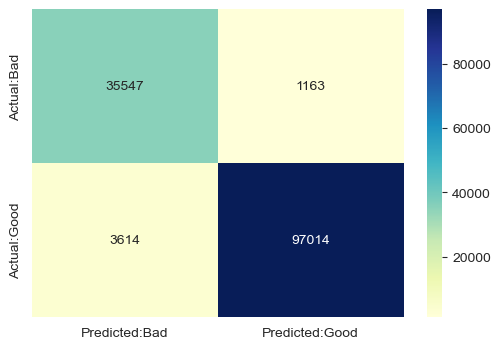

In [92]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### MultinomialNB
* Applying Multinomial Naive Bayes to NLP Problems. Naive Bayes Classifier Algorithm is a family of probabilistic algorithms based on applying Bayes' theorem with the “naive” assumption of conditional independence between every pair of a feature.

In [93]:
from sklearn.naive_bayes import MultinomialNB # nlp algo use to predict good or bad
# create mnb object
mnb = MultinomialNB()

In [94]:
mnb.fit(trainX,trainY)

MultinomialNB()

In [95]:
mnb.score(testX,testY)

0.9588824651589509

*** MultinomialNB gives us 95% accuracy**  

In [96]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.973923026326967
Testing Accuracy : 0.9588824651589509

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.92      0.94      0.93     38170
        Good       0.98      0.97      0.97     99168

    accuracy                           0.96    137338
   macro avg       0.95      0.95      0.95    137338
weighted avg       0.96      0.96      0.96    137338


CONFUSION MATRIX


<AxesSubplot:>

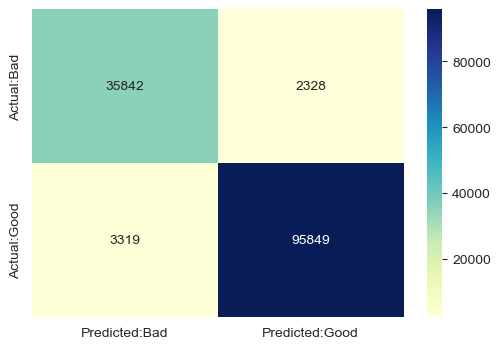

In [97]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

<AxesSubplot:ylabel='Accuracy'>

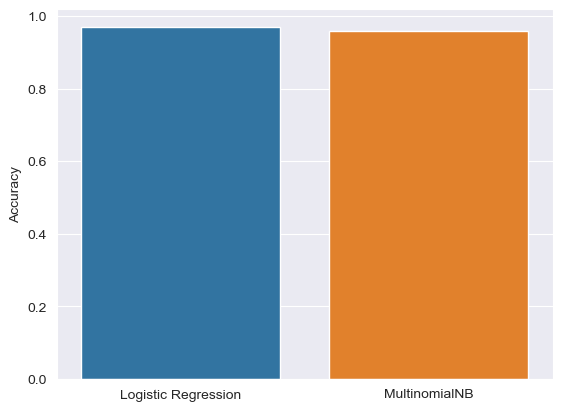

In [98]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index,acc.Accuracy)

*** So, Logistic Regression is the best fit model, Now we make sklearn pipeline using Logistic Regression**

In [99]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())
##(r'\b(?:http|ftp)s?://\S*\w|\w+|[^\w\s]+') ([a-zA-Z]+)([0-9]+)  -- these tolenizers giving me low accuray 

In [100]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [101]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [102]:
pipeline_ls.score(testX,testY) 

0.9654793283723369

Training Accuracy : 0.9793913269305916
Testing Accuracy : 0.9654793283723369

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36765
        Good       0.99      0.97      0.98    100573

    accuracy                           0.97    137338
   macro avg       0.95      0.97      0.96    137338
weighted avg       0.97      0.97      0.97    137338


CONFUSION MATRIX


<AxesSubplot:>

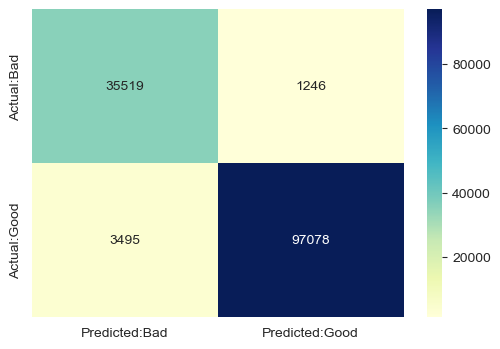

In [103]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [104]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [105]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9654793283723369


***That’s it. See, it's that simple yet so effective. We get an accuracy of 98%. That’s a very high value for a machine to be able to detect a malicious URL with. Want to test some links to see if the model gives good predictions? Sure. Let's do it**

* Bad links => this are phishing sites
yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php
fazan-pacir.rs/temp/libraries/ipad
www.tubemoviez.exe
svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt

* Good links => this are not phishing sites
www.youtube.com/
youtube.com/watch?v=qI0TQJI3vdU
www.retailhellunderground.com/
restorevisioncenters.com/html/technology.html

In [106]:

# predict_good = ["www.google.com"]
# # predict_good.append(input("url"))
# loaded_model = pickle.load(open('phishing.pkl', 'rb'))
# result = loaded_model.predict(predict_good)
# print(result)
# print(predict_good)

# Designing UI part

In [107]:
from tkinter import*

# Top level window
frame = Tk()
frame.title("TextBox Input")
frame.geometry('400x200')
# Function for getting Input
# from textbox and printing it
# at label widget
arr = []
def printInput():
	inp = inputtxt.get(1.0, "end-1c")
	arr.append(inp)
	loaded_model = pickle.load(open('phishing.pkl', 'rb'))
	result = loaded_model.predict(arr)
	lbl.config(text = "Your website is: "+result)

# TextBox Creation
inputtxt = tk.Text(frame,
				height = 5,
				width = 20)
inputtxt.pack()
inputtxt.place(x=100,y=70)

# Button Creation
printButton = tk.Button(frame,
						text = "Print",
						command = printInput)
printButton.pack()


# Label Creation
lbl = tk.Label(frame, text = "")
lbl.pack()
frame.mainloop()


In [109]:
import tkinter as tk
from PIL import Image, ImageTk
import webbrowser

# Top level window
frame = tk.Tk()
frame.title("PWD")
frame.geometry('1920x1080')


# chile1
def websiteBlocker():
	
	frame2 = tk.Toplevel(frame)
	frame2.geometry('650x400')
	frame2.minsize(650,400)
	frame2.maxsize(650,400)
	frame2.title("Website Blocker")

	# child1 fevicon
# 	ico = Image.open('python/blocker_fevicon.png')
# 	photo = ImageTk.PhotoImage(ico)
# 	frame2.wm_iconphoto(False, photo)

	# child1 blocker about 
	heading=tk.Label(frame2, text ='Website Blocker' , font ='arial')
	heading.pack()
	heading.place(x=255,y=10)


	host_path ='C:/windows/System32/drivers/etc/HOSTS'
	redirect = '127.0.0.1'

	def Blocker():
		website_lists = enter_Website.get(1.0,tk.END)
		Website = list(website_lists.split(","))
		with open (host_path , 'r+') as host_file:
			file_content = host_file.read()
			for web in Website:
				if web in file_content:
					display.config(text = 'The website is already Blocked' , font = 'arial')
					display.place(x=185,y=200)
				else:
					host_file.write(redirect + " " + web + '\n')
					display.config( text = "Website blocked", font = 'arial')
					display.place(x=250,y=200)

	# child1 TextBox Creation 
	enter_Website = tk.Text(frame2,
			 font = 'arial',
			 height='1', 
			 width = '40',
			 highlightbackground = "black", 
             highlightthickness = 2)
	enter_Website.pack()
	enter_Website.place(x=100, y= 52)

	# child1 block button
	block_button = tk.Button(frame2, 
			  text = 'Block',
			  font = 'arial',
			  command = Blocker,
			  width = 8,
			  bg = 'royal blue1',
			  activebackground = 'grey')
	block_button.pack()
	block_button.place(x=280 , y = 130)

	# child1 result
	display=tk.Label(frame2, text = '' , font = 'arial')

# Master fevicon
# ico = Image.open('python/test.png')
# photo = ImageTk.PhotoImage(ico)
# frame.wm_iconphoto(False, photo)

# Function for getting Input
# from textbox and printing it
# at label widget

# Master logo name
logo = tk.Label(frame,
		text = "Phishing Website Detector", 
		font=(("Times New Roman"), 35))
logo.place(x=420,y=25)

# Master about
enterURL = tk.Label(frame,
		    text = "About us:\n Hello welcome to Phishing website detection App, To check the website is phishable paste website ULR in the below textbox and click check",
			width=110, 
			font=(("Times New Roman"),10))
enterURL.pack()
enterURL.place(x=277,y=80) 

# Master enter link label
enterURL = tk.Label(frame,
		    text = "Enter link: ", 
			font=(("Times New Roman"), 13))
enterURL.place(x=87,y=150) 

# Master TextBox Creation
inputtxt = tk.Text(frame,
				height = 1,
				width = 120,
	        	pady =5,
				bd =0,
				highlightbackground = "black", 
                highlightthickness = 2 
				)

inputtxt.place(x=171,y=150)
inputtxt.insert(tk.END,'Enter URL:')



# Master result
def printInput():
	arr = []
	inp = inputtxt.get(1.0, "end-1c")
	arr.append(inp)
	loaded_model = pickle.load(open('phishing.pkl', 'rb'))
	result = loaded_model.predict(arr)
	if result == "bad":
		lbl.config(text = "WARINIG\nThe URL of website you have entered is phishing website,Don't enter your any personal detail on this website", 
	     fg = "red")
	elif result == "good":
		lbl.config(text = "RESULT\nThe URL of website you have entered is safe website,You can enter your any personal detail on this website", 
	     fg = "green")


# Master check button Creation

printButton = tk.Button(frame,
						text = "Check",
						command = printInput,
						width=20, 
						height=1,
						bg = "black", 
						fg = "white",
						bd=0,
						font=(("Times New Roman"), 15),
						activebackground = 'grey')
printButton.pack()
printButton.place(x=535,y=193)

# Master block button 
blockbutton = tk.Button(frame,
						text = "Block",
						command = websiteBlocker,
						width=15, 
						height=2,
						bg = "black", 
						fg = "white",
						bd=0,
						font=(("Times New Roman"), 17),
						activebackground = 'grey')
blockbutton.pack()
blockbutton.place(x=420,y=350)

# Master report button
def reportButton(reporturl):
		webbrowser.open_new_tab(reporturl)

reportbutton = tk.Button(frame,
				text = "Report",
				command = reportButton,
				width=15, 
				height=2,
				bg = "black", 
				fg = "white",
				bd=0,
				font=(("Times New Roman"), 17))
reportbutton.pack()
reportbutton.place(x=670,y=350)
reportbutton.bind("<Button-1>", lambda e:
reportButton(reporturl="https://safebrowsing.google.com/safebrowsing/report_phish/?hl=en"))

# Master result
lbl = tk.Label(frame, 
	       		text = "",
				font=(("Times New Roman"), 16))
lbl.pack()
lbl.place(x=195,y=250)

# Master feedback button
def callback(url):
   webbrowser.open_new_tab(url)

link = tk.Label(frame, 
		text="Feedback",
		font=("Times New Roman", 15), 
		fg="white", 
		cursor="hand2",
		bg = "blue",
		width=120)
link.pack()
link.bind("<Button-1>", lambda e:
callback("https://docs.google.com/forms/d/e/1FAIpQLSce6OK20lsoXa6JhvpVNaBbKczoQyJV2XOIJFfQbN1k8Iufjw/viewform?usp=sf_link"))
link.place(x=0,y=550)

frame.mainloop()
